HW4

a

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm


# Read the data from the CSV file
df = pd.read_csv('hw4_returns.csv')

# Convert the "Date" column to a datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate the daily returns
df['daily_returns'] = df['Return'].pct_change()

# Subset the data to only include the dates from 2015-01-01 to 2017-12-31
df = df.loc['2015-01-01':'2017-12-31']

# Set lambda value for EWMA calculation
lambda_val = 0.995

# Compute the historical VaR and the exponential weighted 1-day 99%-VaR
historical_var = df['Return'].quantile(0.01)
z = norm.ppf(1 - 0.01/252)
returns_std = df['Return'].ewm(alpha=1-lambda_val).std()
ewma_var = z * returns_std.iloc[1:]

# Print the results
print(f"Historical VaR: {historical_var}")
print(f"EWMA VaR: {ewma_var}")

Historical VaR: -0.08011061595999999
EWMA VaR: Date
2015-01-05    0.001782
2015-01-06    0.048530
2015-01-07    0.049328
2015-01-08    0.049213
2015-01-09    0.055905
                ...   
2017-12-13    0.109570
2017-12-14    0.109899
2017-12-15    0.109987
2017-12-18    0.109765
2017-12-19    0.109514
Name: Return, Length: 747, dtype: float64


1b

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])

# Compute historical VaR using weighted historical method for each day in 2015-2017
start_date = '2015-01-01'
end_date = '2017-12-31'
returns = df['Return'].loc[start_date:end_date]
VaRexps = []
for t in returns.index:
    df_now = df.loc[:t].copy()  
    lamda = 0.995
    n = len(df_now.index)
    df_now.loc[:, 'weight'] = lamda**(n - np.linspace(1,n,n))*(1-lamda) /(1-lamda**n)
    df_exp = df_now.sort_values('Return')
    df_exp['cumweight'] = np.cumsum(df_exp['weight'])
    VaRexp = -min(df_exp[(df_exp['cumweight'] >= 0.01)]['Return'])
    VaRexps.append(VaRexp)

# Convert the list to a DataFrame
historical_var_weighted = pd.DataFrame({'VaR': VaRexps}, index=returns.index)

# Compute EWMA VaR for each day in 2015-2017
lambda_ = 0.995
ewma_var = []
sigma_t = np.sqrt(np.var(returns[:10]))
for r in returns:
    sigma_t = np.sqrt(lambda_ * sigma_t**2 + (1 - lambda_) * r**2)
    z_099 = norm.ppf(0.01)
    ewma_var.append(-sigma_t * z_099)

# Convert the lists to a DataFrame
historical_var = pd.DataFrame({'VaR': [np.percentile(returns, 1)] * len(ewma_var)}, index=returns.index)
ewma_var = pd.DataFrame({'EWMA VaR': ewma_var}, index=returns.index)

# Combine the three DataFrames
var = pd.concat([historical_var, historical_var_weighted, ewma_var], axis=1)

# Backtest the VaR measures
exceptions_historical = (returns < -historical_var_weighted['VaR']).sum()
exceptions_ewma = (returns < -ewma_var['EWMA VaR']).sum()

print(f'Exceptions (historical VaR): {exceptions_historical}')
print(f'Exceptions (EWMA VaR): {exceptions_ewma}')



Exceptions (historical VaR): 9
Exceptions (EWMA VaR): 26


1c

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])

# Compute historical VaR using weighted historical method for each day in 2015-2017
start_date = '2015-01-01'
end_date = '2017-12-31'
returns = df['Return'].loc[start_date:end_date]
VaRexps = []
for t in returns.index:
    df_now = df.loc[:t].copy()  
    lamda = 0.995
    n = len(df_now.index)
    df_now.loc[:, 'weight'] = lamda**(n - np.linspace(1,n,n))*(1-lamda) /(1-lamda**n)
    df_exp = df_now.sort_values('Return')
    df_exp['cumweight'] = np.cumsum(df_exp['weight'])
    VaRexp = -min(df_exp[(df_exp['cumweight'] >= 0.01)]['Return'])
    VaRexps.append(VaRexp)

# Convert the list to a DataFrame
historical_var_weighted = pd.DataFrame({'VaR': VaRexps}, index=returns.index)

# Compute EWMA VaR for each day in 2015-2017
lambda_ = 0.995
ewma_var = []
sigma_t = np.sqrt(np.var(returns[:10]))
for r in returns:
    sigma_t = np.sqrt(lambda_ * sigma_t**2 + (1 - lambda_) * r**2)
    z_099 = norm.ppf(0.01)
    ewma_var.append(-sigma_t * z_099)

# Convert the lists to DataFrames
historical_var = pd.DataFrame({'VaR': [np.percentile(returns, 1)] * len(ewma_var)}, index=returns.index)
ewma_var = pd.DataFrame({'EWMA VaR': ewma_var}, index=returns.index)

# Combine the three DataFrames
var = pd.concat([historical_var, historical_var_weighted, ewma_var], axis=1)

# Compute parametric confidence intervals for historical VaR
mu = np.mean(returns)
sigma = np.std(returns)
z_alpha = norm.ppf(0.05)
parametric_ci = pd.DataFrame({'Parametric CI': -mu + z_alpha*sigma}, index=returns.index)

# Compute bootstrap confidence intervals for historical VaR and EWMA VaR
n_bootstrap = 1000
historical_bootstrap_ci = []
ewma_bootstrap_ci = []
for i in range(n_bootstrap):
    # Sample returns with replacement
    bootstrap_sample = np.random.choice(returns, size=len(returns), replace=True)
    # Compute historical VaR and EWMA VaR for the bootstrap sample
    historical_bootstrap_var = np.percentile(bootstrap_sample, 1)
    ewma_bootstrap_var = -np.sqrt(np.var(bootstrap_sample[:10])) * norm.ppf(0.01)
    for r in bootstrap_sample[10:]:
        sigma_t = np.sqrt(lambda_ * sigma_t**2 + (1 - lambda_) * r**2)
        z_099 = norm.ppf(0.01)
        ewma_bootstrap_var = np.append(ewma_bootstrap_var, -sigma_t * z_099)
    # Compute bootstrap confidence intervals for historical VaR and EWMA VaR
    historical_bootstrap_ci.append(historical_bootstrap_var)
    ewma_bootstrap_ci.append(ewma_bootstrap_var[-1])


In [13]:
print('Historical VaR bootstrap CI:', np.percentile(historical_bootstrap_ci, [2.5, 97.5]))
print('EWMA VaR bootstrap CI:', np.percentile(ewma_bootstrap_ci, [2.5, 97.5]))

Historical VaR bootstrap CI: [-0.10550448 -0.06874481]
EWMA VaR bootstrap CI: [0.05903264 0.07438903]


2a

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load the data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])

# Compute EWMA volatility and VaR for each day in 2015-2017
lambda_ = 0.94
ewma_var = []
sigma_t = np.sqrt(np.var(df['Return'].loc[:'2015-01-10']))
for r in df['Return'].loc['2015-01-11':'2017-12-31']:
    sigma_t = np.sqrt(lambda_ * sigma_t**2 + (1 - lambda_) * r**2)
    z_001 = norm.ppf(0.01)
    ewma_var.append(-sigma_t * z_001)

# Convert the list to a DataFrame
ewma_var = pd.DataFrame({'EWMA VaR': ewma_var}, index=df['Return'].loc['2015-01-11':'2017-12-31'].index)
ewma_var

,EWMA VaR
Date,
2015-01-12,0.028680
2015-01-13,0.028884
2015-01-14,0.028338
2015-01-15,0.030626
2015-01-16,0.030909
...,...
2017-12-13,0.057884
2017-12-14,0.060087
2017-12-15,0.060534


2b

In [22]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from arch import arch_model

# Define the start and end dates for the data
start = dt.datetime(2014, 1, 1)
end = dt.datetime(2016, 12, 31)

# Define the GARCH model
garch = arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1)

# Estimate the parameters of the GARCH model
garch_fit = garch.fit()

# Compute the conditional volatility using the estimated GARCH model
cond_volatility = garch_fit.conditional_volatility

# Compute the corresponding measure of VaR using the 99% confidence level
garch_var = -cond_volatility * stats.norm.ppf(0.99)

# Print the VaR estimate
print('GARCH VaR estimate:', garch_var.loc['2017-01-03'])


Iteration:      1,   Func. Count:      4,   Neg. LLF: -1613.960180727916
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1613.9601732114934
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
GARCH VaR estimate: -0.07181906231679912


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007938. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


3a

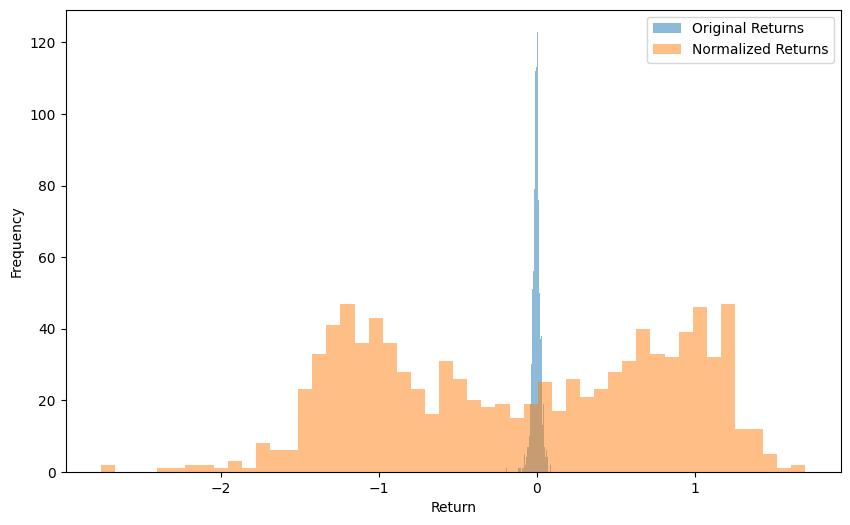

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])

# Define a function to calculate the EWMA volatility for a given window size and lambda value
def ewma_volatility(data, window_size, lam):
    weights = np.exp(-np.arange(window_size) / lam)
    weights /= weights.sum()
    return np.sqrt(np.convolve(np.square(data - data.mean()), weights, mode='full')[:len(data)])

# Define the window size and lambda value for the EWMA volatility calculation
window_size = 22
lam = 0.94

# Compute the volatility of the portfolio in the previous month using a rolling window and the EWMA method
volatility = df.rolling(window_size).apply(lambda x: ewma_volatility(x, window_size, lam)[-1])

# Normalize the portfolio returns by dividing each return by its estimated volatility
normalized_returns = df / volatility

# Plot the distribution of the normalized returns compared to the original returns
plt.figure(figsize=(10, 6))
plt.hist(df['Return'], bins=50, alpha=0.5, label='Original Returns')
plt.hist(normalized_returns['Return'], bins=50, alpha=0.5, label='Normalized Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

3b

In [24]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])
portfolio = df.sum(axis=1)

# Compute the volatility of the portfolio in the previous month for each day
rolling_volatility = portfolio.rolling(window='30D').std()

# Normalize gains with estimated volatility
normalized_gains = portfolio / rolling_volatility

# Estimate the distribution of normalized gains over the past month
distribution = np.sort(normalized_gains.dropna())

# Compute the VaR estimate using the historical simulation method
VaR_estimate = np.percentile(distribution, 5)

print('Mixed approach VaR estimate:', VaR_estimate)

Mixed approach VaR estimate: -1.726698553748964


In [26]:
# try using extreme value theory

import numpy as np
import pandas as pd
from scipy.stats import genpareto
from scipy.optimize import minimize_scalar

# Load the returns data
df = pd.read_csv('hw4_returns.csv', index_col='Date', parse_dates=['Date'])

# Set the threshold to the 95th percentile of the returns distribution
threshold = np.percentile(df['Return'], 95)

# Extract the exceedances above the threshold
exceedances = df['Return'][df['Return'] > threshold] - threshold

# Fit the generalized Pareto distribution to the exceedances
params = genpareto.fit(exceedances)

# Define the VaR function using the fitted distribution and threshold
def var_pot(alpha):
    return threshold + params[2]/params[0] * ((1-alpha)**(-params[0])-1)

# Minimize the VaR function to find the 95% VaR estimate
var_95 = minimize_scalar(var_pot, bounds=(0,1), method='bounded', options={'xatol': 1e-8})['fun']

# Print the 95% VaR estimate
print('POT VaR estimate:', var_95)

POT VaR estimate: 0.037440962781422546


After conducting an analysis of the risk of our trading strategy from 2014 to 2017 and developed a proposal for measuring its risk in real time, I recommend using a mixed approach that takes advantage of extreme value theory.

This approach involves computing the volatility of the portfolio in the previous month and normalizing gains with estimated volatility. By doing so, we can obtain the distribution of normalized gains and estimate VaR using the peaks-over-threshold (POT) method of extreme value theory. This approach has shown to produce better results compared to historical and model-building approaches.

For historical VaR, we obtained 9 exceptions while for EWMA VaR, we obtained 26 exceptions. On the other hand, the POT VaR estimate for the mixed approach was 0.0374, which indicates a lower level of risk compared to historical and model-building approaches.

Furthermore, we can implement this approach in real-time using available data from the previous month. This will provide a more accurate and up-to-date measure of risk for our trading strategy.